## EPS/ESE 135: Observing the Ocean
### Data Analysis Assignment 2 (Intro): The Equation of State

In class this week you will learn about the equation of state. This is a thermodynamic equation that relates the density of ocean water to temperature, salinity, and pressure.

At the simplest level, the density of seawater increases with salinity and decreases with temperature. It is possible to approximate this as a linear function, e.g. $\rho(T,S) = \beta S - \alpha T$, where $\rho$ is density, $S$ is salinity, $T$ is temperature, and $\beta$ and $\alpha$ are coefficients.

However, in reality, the equation of state of seawater is nonlinear and also depends on pressure. Oceanographers widely use a collection of functions called the [Gibbs-SeaWater (GSW) Oceanographic Toolbox](https://www.teos-10.org/software.htm) to standardize conversions between the variables that our instruments can measure (e.g. in situ temperature, conductivity, and pressure) to derived quantities like potential temperature, salinity, and density that we use in our analyses.

The documentation for the python implementation of the GSW toolbox is [here](https://teos-10.github.io/GSW-Python/). (The Matlab version of GSW has more functions and [more-detailed documentation](https://www.teos-10.org/pubs/gsw/html/gsw_contents.html).)

In [4]:
# import python libraries to be used in this assignment
import pandas as pd
import matplotlib.pyplot as plt

import gsw
from ts_plot import ts_plot

# if you get an error from running this cell:
# 1. double check that you are using the eps135 python environment!
# 2. make sure ts_plot.py is saved in the folder where you are running this notebook.

For this assignment, I will walk you through some of the most commonly used GSW functions using the same CTD (Conductivity-Temperature-Depth) profile from southeast Greenland that you plotted in the last assignment. Then you will do the same using a different profile.

In [6]:
# load CTD data and display pandas dataframe
ctd = pd.read_csv('ctd_raw.csv')
ctd

,pres,temp,sal
0,1.346000,4.028200,28.639988
1,2.007944,4.197800,28.838233
2,3.139750,5.358433,30.141808
3,4.045600,5.729352,30.936060
4,4.966909,5.765445,31.389000
...,...,...,...
463,469.171769,4.477615,34.778523
464,470.181538,4.477400,34.778969
465,471.236308,4.477392,34.778885
466,472.232286,4.477336,34.778786


The variables we are starting with are pressure [dbar], temperature [deg C], and salinity [psu]. Pressure and (in situ) temperature are quantities that are measured by the CTD sensors. Salinity is derived from conductivity and temperature, but many oceanographic instruments come with processing software that will output a practical salinity variable.

The derived quantities we will compute are:
* $z$, depth [m]
* $\theta$, potential temperature [deg C]
* CT, Conservative Temperature [deg C]
* SA, Absolute Salinity [g/kg]
* $\rho$, in situ density [kg/m3]
* $\sigma_0$, potential density anomaly [kg/m3]

Click on [Documentation for GSW conversion functions](https://teos-10.github.io/GSW-Python/conversions.html). This page includes the documentation for the first 4 calculations. Each function has a name in the form `gsw.x_from_y`, where `x` is the quantity we want to compute and `y` is what we (hopefully) have.

Scroll to the very bottom to see the documentation for `gsw.conversions.z_from_p`. This is a function that will calculate `z`, depth, from `p`, pressure.

The syntax for this function is `gsw.z_from_p(pressure,latitude)`. (The other inputs are optional.) The documentation tells you that the input parameters are pressure (p) in dbar and latitude (lat) in degrees.

In [9]:
# The latitude and longitude for this profile are saved in the text file ctd_meta.txt.
# I am saving them as variables because I'll need them a few times.
ctd_lat = 65.5
ctd_lon = -38.3

### Converting pressure to depth

In [11]:
# Now I have the inputs I need to calculate the depth variable for this profile.
gsw.z_from_p(ctd.pres,ctd_lat)

0       -1.332756
1       -1.988185
2       -3.108844
3       -4.005768
4       -4.917995
          ...    
463   -464.030284
464   -465.027857
465   -466.069881
466   -467.053820
467   -467.916310
Name: pres, Length: 468, dtype: float64

The values of `z` look quite similar to the values of `pres` but they are negative. This is because GSW defines `z` as height above sea-level. I prefer to use positive values of depth in meters so I will multiply this variable by -1 and add it to my dataframe.

In [13]:
# By putting ctd['dep'] on the left of the equals sign I am adding the output to the dataframe 'ctd'
ctd['dep'] = gsw.z_from_p(ctd.pres,ctd_lat)*-1

# Display a summary of 'ctd' to confirm that this has been added and the values make sense.
ctd

,pres,temp,sal,dep
0,1.346000,4.028200,28.639988,1.332756
1,2.007944,4.197800,28.838233,1.988185
2,3.139750,5.358433,30.141808,3.108844
3,4.045600,5.729352,30.936060,4.005768
4,4.966909,5.765445,31.389000,4.917995
...,...,...,...,...
463,469.171769,4.477615,34.778523,464.030284
464,470.181538,4.477400,34.778969,465.027857
465,471.236308,4.477392,34.778885,466.069881
466,472.232286,4.477336,34.778786,467.053820


You might notice that the values of pressure [dbar] and depth [m] are more similar near the top (surface) than near the bottom. Let's make a plot to visualize this relationship.

Text(0.5, 1.0, 'Difference between pressure and depth over profile')

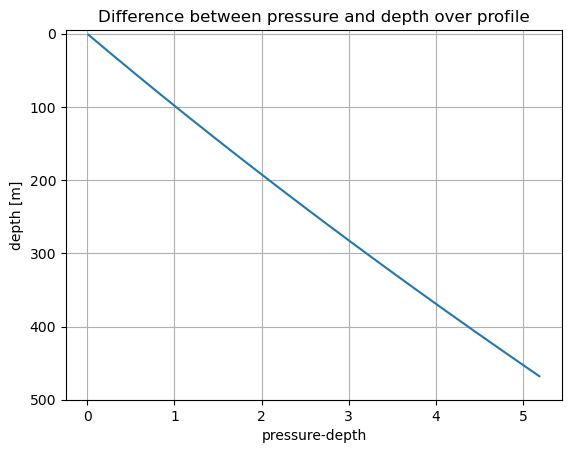

In [15]:
# calculate the difference between pressure and depth at each point in the profile
# save this as variable delta_p
delta_p = ctd.pres-ctd.dep

# plot delta_p (x-axis) versus depth (y-axis)
plt.plot(delta_p, ctd.dep)

# flip y-axis so that surface is at top
plt.ylim(500,-5)

# add grid lines
plt.grid()

# add axis labels
plt.xlabel('pressure-depth')
plt.ylabel('depth [m]')
plt.title('Difference between pressure and depth over profile')

The plot shows that the offset continues to increase with depth. From 0 to 100 m, the offset increases from approx. 0.01 to 1, and from 100 to 200 m it increases from 1 to 2.1. At the bottom (467 m) the offset is about 5.2. The grid lines help to visualize that this is not a linear change with depth.

### Calculating Absolute Salinity

Most of the GSW conversions require you to first calculate the "Absolute Salinity." The salinity variable we are given in this data file is **practical salinity**, and its units are "practical salinity units," which are calculated based on the measured conductivity don't directly correspond to a physical measurement (you will learn more about this in class). The **Absolute Salinity** is a function of practical salinity, as well as the location of the measurement, and is intended to give a more physical measurement of the mass fraction of salt in the seawater in units of grams per kilogram. (See documentation for `gsw.conversions.SA_from_SP(SP, p, lon, lat)`.)

In [19]:
# Calculate SA and add to ctd dataframe.
ctd['SA'] = gsw.SA_from_SP(ctd.sal, ctd.pres, ctd_lon, ctd_lat)

# Display summary of 'ctd'
ctd

,pres,temp,sal,dep,SA
0,1.346000,4.028200,28.639988,1.332756,28.776571
1,2.007944,4.197800,28.838233,1.988185,28.975754
2,3.139750,5.358433,30.141808,3.108844,30.285529
3,4.045600,5.729352,30.936060,4.005768,31.083555
4,4.966909,5.765445,31.389000,4.917995,31.538642
...,...,...,...,...,...
463,469.171769,4.477615,34.778523,464.030284,34.945172
464,470.181538,4.477400,34.778969,465.027857,34.945621
465,471.236308,4.477392,34.778885,466.069881,34.945538
466,472.232286,4.477336,34.778786,467.053820,34.945440


Text(0.5, 1.0, 'Comparison between practical and absolute salinity')

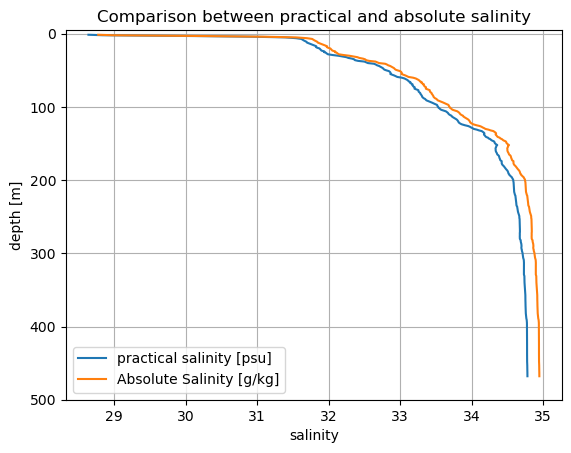

In [20]:
# Plot both the practical and absolute salinity profiles on the same axes.
# Include labels so that we can add a legend to distinguish between the two lines.
plt.plot(ctd.sal, ctd.dep, label = 'practical salinity [psu]')
plt.plot(ctd.SA,  ctd.dep, label = 'Absolute Salinity [g/kg]')

# Flip y-axis so that surface is at top.
plt.ylim(500, -5)

# Add legend
plt.legend()

# Add grid lines
plt.grid()

# Add axis labels and plot title
plt.ylabel('depth [m]')
plt.xlabel('salinity')
plt.title('Comparison between practical and absolute salinity')

You can see that the values are similar and the basic shape of the profiles is the same, but there is an offset between practical and Absolute Salinity. Whenever you are reporting salinity values, be clear about which you are using.

### Calculating potential and Conservative Temperature

Now we will do the same to calculate and plot potential temperature and Conservative Temperature.

The temperature measured by the CTD (and included in this data file) is the **in situ temperature**. **Potential temperature** represents the temperature that a parcel of water would have if it were raised to the ocean surface (0 dbar), removing any effect of compression on temperature. **Conservative temperature** is a measure of the heat content in a water parcel expressed in units of temperature. All three have units of degrees Celsius.

We will calculate and plot:
1. Potential temperature, $\theta$: `gsw.conversions.pt0_from_t(SA, t, p)`
2. Conservative temperature, CT: `gsw.conversions.CT_from_t(SA, t, p)`

In [25]:
# calculate potential temperature and add to dataframe
ctd['theta'] = gsw.pt0_from_t(ctd.SA, ctd.temp, ctd.pres)

# calculate conservative temperature and add to dataframe
ctd['CT'] = gsw.CT_from_t(ctd.SA, ctd.temp, ctd.pres)

# show dataframe summary
ctd

,pres,temp,sal,dep,SA,theta,CT
0,1.346000,4.028200,28.639988,1.332756,28.776571,4.028122,4.084370
1,2.007944,4.197800,28.838233,1.988185,28.975754,4.197680,4.253450
2,3.139750,5.358433,30.141808,3.108844,30.285529,5.358209,5.408459
3,4.045600,5.729352,30.936060,4.005768,31.083555,5.729045,5.772046
4,4.966909,5.765445,31.389000,4.917995,31.538642,5.765063,5.802782
...,...,...,...,...,...,...,...
463,469.171769,4.477615,34.778523,464.030284,34.945172,4.441933,4.438648
464,470.181538,4.477400,34.778969,465.027857,34.945621,4.441638,4.438348
465,471.236308,4.477392,34.778885,466.069881,34.945538,4.441547,4.438258
466,472.232286,4.477336,34.778786,467.053820,34.945440,4.441411,4.438123


Text(0.5, 1.0, 'Comparison between temperature variables')

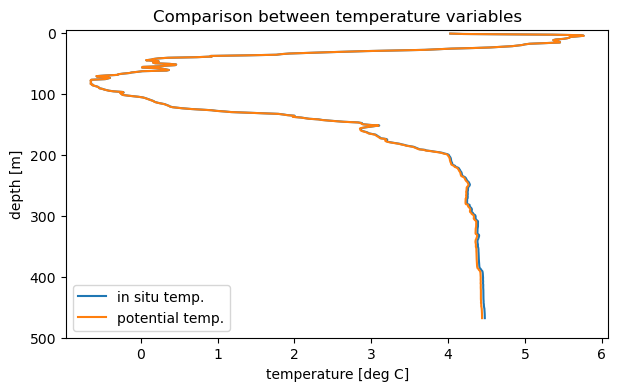

In [26]:
# This will stretch out the x-axis slightly so you can see differences between 
# the variables.
plt.figure(figsize = (7,4))

# Plot all 3 temperature profiles together.
# I commented out CT because it made it harder to see, but feel free to add it 
# after you look at the first two.
plt.plot(ctd.temp, ctd.dep, label = 'in situ temp.')
plt.plot(ctd.theta, ctd.dep, label = 'potential temp.')
# plt.plot(ctd.CT, ctd.dep, label = 'conservative temp.')

# Flip y-axis
plt.ylim(500, -5)

# Add legend
plt.legend()

# Add axis labels
plt.ylabel('depth [m]')
plt.xlabel('temperature [deg C]')
plt.title('Comparison between temperature variables')

Again, the values are similar between the temperature variables. When looking at just in situ and potential temperature together on this scale, they appear to fully overlap over much of the profile, and start to diverge slightly in the lower third or so, where in situ temperature starts to look very slightly warmer. You can uncomment the third plot command to see conservative temperature as well, which looks very similar to potential temperature.

### Calculating in situ and potential density

As described at the top and in lecture, the density of ocean water is primarily determined by its temperature and salinity. However, like in situ temperature, density also increases with pressure. Therefore, we also have multiple ways of calculating and expressing density for different applications.

**In situ density** is the actual measured density of seawater with pressure effects included. **Potential density** is the density a parcel of water would have if raised to the surface (0 dbar). Furthermore, we often express this as an anomaly by subtracting 1000 kg/m$^3$, which is the maximum density of freshwater, giving us the **potential density anomaly**.

We will calculate and plot:
1. In situ density, $\rho$: `gsw.density.rho(SA, CT, p)`
2. Potential density anomaly, $\sigma_0$: `gsw.density.sigma0(SA, CT)`

In [31]:
# calculate in situ density and add to dataframe
ctd['rho'] = gsw.rho(ctd.SA, ctd.CT, ctd.pres)

# calculate potential density anomaly and add to dataframe
ctd['sigma'] = gsw.sigma0(ctd.SA, ctd.CT)

# show dataframe summary
ctd

,pres,temp,sal,dep,SA,theta,CT,rho,sigma
0,1.346000,4.028200,28.639988,1.332756,28.776571,4.028122,4.084370,1022.736791,22.730464
1,2.007944,4.197800,28.838233,1.988185,28.975754,4.197680,4.253450,1022.882162,22.872735
2,3.139750,5.358433,30.141808,3.108844,30.285529,5.358209,5.408459,1023.804828,23.790219
3,4.045600,5.729352,30.936060,4.005768,31.083555,5.729045,5.772046,1024.395510,24.376750
4,4.966909,5.765445,31.389000,4.917995,31.538642,5.765063,5.802782,1024.753443,24.730434
...,...,...,...,...,...,...,...,...,...
463,469.171769,4.477615,34.778523,464.030284,34.945172,4.441933,4.438648,1029.730603,27.565208
464,470.181538,4.477400,34.778969,465.027857,34.945621,4.441638,4.438348,1029.735628,27.565596
465,471.236308,4.477392,34.778885,466.069881,34.945538,4.441547,4.438258,1029.740416,27.565539
466,472.232286,4.477336,34.778786,467.053820,34.945440,4.441411,4.438123,1029.744928,27.565477


Text(0.5, 1.0, 'Comparison between density variables')

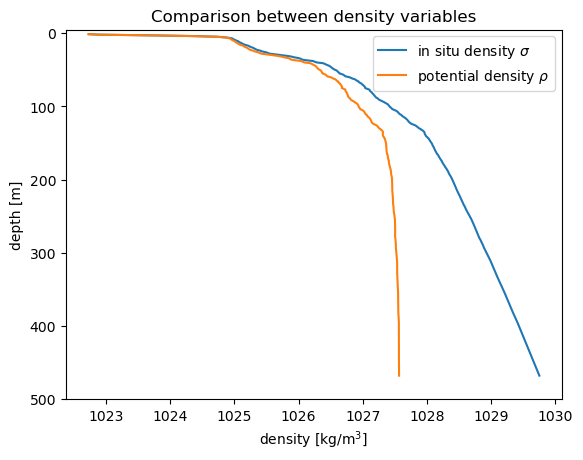

In [32]:
# plot in situ density (rho) profile
plt.plot(ctd.rho,ctd.dep, label = r'in situ density $\sigma$')

# plot potential density (sigma) profile, adding 1000 kg/m3 to compare to rho
plt.plot(ctd.sigma+1000,ctd.dep, label = r'potential density $\rho$')

# flip y-axis
plt.ylim(500, -5)

# add legend
plt.legend()

# add axis labels
plt.ylabel(r'depth [m]')
plt.xlabel(r'density [kg/m$^3$]')
plt.title(r'Comparison between density variables')

You can see that the pressure dependence of in situ density is pretty dramatic compared to temperature over this depth range! The potential density profile shows that the density gradient, or **stratification**, is much stronger in the upper 150 m than it is over the lower 200 m, while the in situ density profile suggests more continuous stratification due to the effect of pressure.

### Plotting temperature versus salinity 

In your previous assigment, I asked you to describe the temperature and salinity profiles individually. When two water parcels with different temperatures and salinities come into contact, the heat and salt generally mix together linearly, so it's often helpful to plot them together on one axis in addition to side-by-side, like you did last time.

First, a refresher on subplots:

Text(0.5, 1.0, 'CTD profile from southeast Greenland')

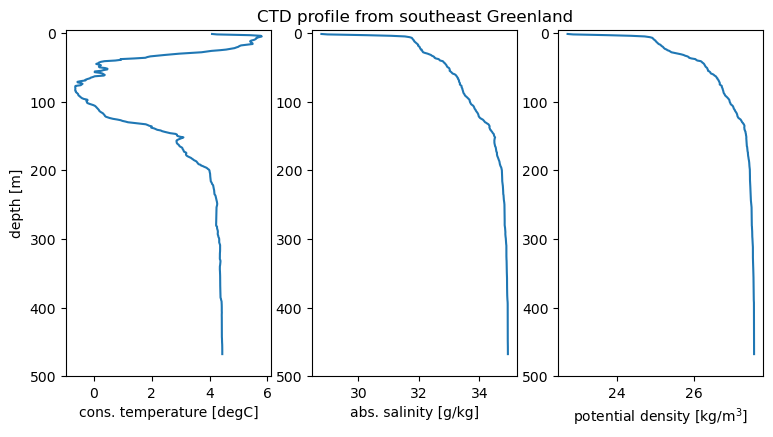

In [37]:
# create fig and ax objects using plt.subplots(_____) command:
# create 1 row of 3 subplots using syntax plt.subplots(rows,cols, ...)
# second argument figsize=(length,height)
fig,ax = plt.subplots(1,3, figsize=(9,4.5)) 

#now modify each subplot with ax[0], ax[1], ax[2]...

# plot conservative temperature profile on left
ax[0].plot(ctd.CT, ctd.dep)
ax[0].set_ylim(500, -5)
ax[0].set_xlabel(r'cons. temperature [degC]')
ax[0].set_ylabel(r'depth [m]')

# plot salinity profile in middle
ax[1].plot(ctd.SA, ctd.dep)
ax[1].set_ylim(500, -5)
ax[1].set_xlabel(r'abs. salinity [g/kg]')

# plot potential density anomaly profile on right
ax[2].plot(ctd.sigma, ctd.dep)
ax[2].set_ylim(500, -5)
ax[2].set_xlabel(r'potential density [kg/m$^3$]')

# add title to middle subplot
ax[1].set_title(r'CTD profile from southeast Greenland')

Looking at these side-by-side, you might notice that the density looks quite a lot like the salinity.

I've given you a function called `ts_plot` (saved in the `teos_fns.py` module). This function will create a figure with contour lines of constant density ($\sigma$) given a range of temperature and salinity values. Then you can plot data on top of it.

The syntax is: `ts_plot(SA, CT, plot_data, num_isopycs, col_contour, sigma_round)`
* `SA` -- salinity data or salinity range
* `CT` -- temperature data or temperature range
* `plot_data` -- optional, default is 0 (True/False). Set to 1 to automatically plot data.
* `num_isopycs` -- optional, default is 10 (integer). Set to choose how many contour lines to plot.
* `col_contour` -- optional, default is 'k' (color). Set to choose color of density contours.
* `sigma_round` -- optional, default is 0.25 (number). Set to choose max precision of density contours.

Here's an example of how it works, using a range of temperature and salinity values that roughly cover the typical range of properties in the global ocean.

Text(0.5, 1.0, 'Potential density anomaly $\\sigma$ [kg/m$^3$]')

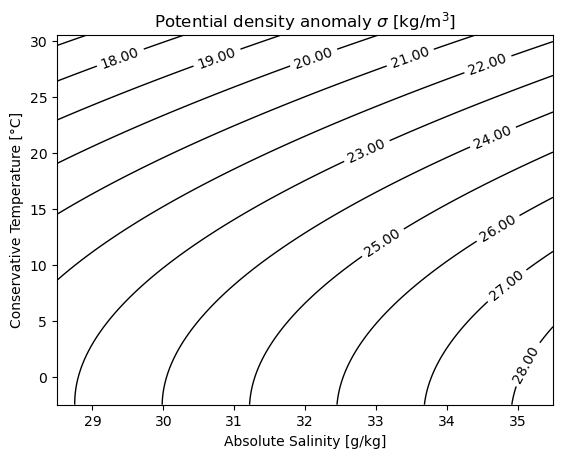

In [78]:
# choose max and min values for SA and CT
SArange = (29,35)
CTrange = (-2, 30)

# Generate a contour plot of potential density for these ranges
ts_plot(SArange,CTrange)

# the function automatically adds the x and y labels but let's add a title
plt.title(r'Potential density anomaly $\sigma$ [kg/m$^3$]')

You can see the density contours (**isopycnals**) curving because the equation of state is nonlinear. For example, follow the 23 kg/m$^3$ contour line from bottom left to top right. At very low temperatures, the tangent to the contour is nearly vertical, which means that salinity has a stronger effect on density than temperature does. But at higher temperatures, the effect of temperature becomes larger.

Now let's plot our CTD profile on a similar figure.

Text(0.5, 1.0, 'Temperature-Salinity plot')

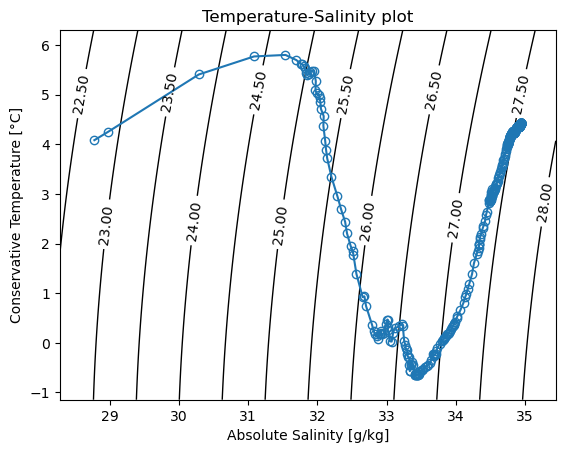

In [44]:
# use the ts_plot function to plot the background density contours
ts_plot(ctd.SA, ctd.CT)

# use the plot command to plot the data points on top
# '-o' tells matplotlib to plot a solid line ('-') and a circle ('o') at each point
# markerfacecolor='none' makes the circles empty
plt.plot(ctd.SA, ctd.CT, '-o', markerfacecolor='none')

plt.title('Temperature-Salinity plot')

All of the water is relatively cold so the y-axis on this plot only goes from about -1 to 6 degrees Celsius, while the salinity range is relatively large. As mentioned above, the density at low temperature depends very strongly on salinity, so the isopycnals appear very steep. This is why the salinity and density profiles have such similar shapes, despite the significant changes in temperature with depth.

So in this plot, the surface ocean (low density) is to the left. As you move toward the right, the water gets saltier and therefore denser. This plot shows temperature increasing initially, then decreasing, and then increasing again. But even as the deeper waters get warmer with depth, salinity continues to increase. This means that density is highest at the bottom and the water column is stable.